In [1]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
import seaborn as sns
import matplotlib.patches as patches
import random

In [2]:
path = '/Users/aleksandralomakina/Downloads/UECFOOD256'
categories = 'category.txt'
bbox_files = 'bb_info.txt'
imgs_format = 'jpg'

In [3]:
category_ids = []
category_names = []
with open(path+'/'+categories, 'r') as list_:
    for i,line in enumerate(list_):
        if(i > 0): # skip header
            line = line.rstrip('\n')
            line = line.split('\t')
            category_ids.append(int(line[0]))
            category_names.append(line[1])

In [4]:
print(f'Общее число категорий продуктов: {len(category_names)}')

Общее число категорий продуктов: 256


In [5]:
categories_images = []
categories_bbox_info = []
for id_pos, id in enumerate(category_ids):
    # Create empty list for images list and bbox info
    categories_images.append([])
    categories_bbox_info.append([])
    
    # Read file
    imgs_file_list = path+'/'+str(id)+'/'+bbox_files
    with open(imgs_file_list, 'r') as list_:
        for i,line in enumerate(list_):
            if(i > 0): # skip header
                line = line.rstrip('\n')
                line = line.split(' ')
                categories_images[id_pos].append(line[0])
                line = line[1:]
                for j,l in enumerate(line):
                    line[j] = float(l)
                categories_bbox_info[id_pos].append(line)

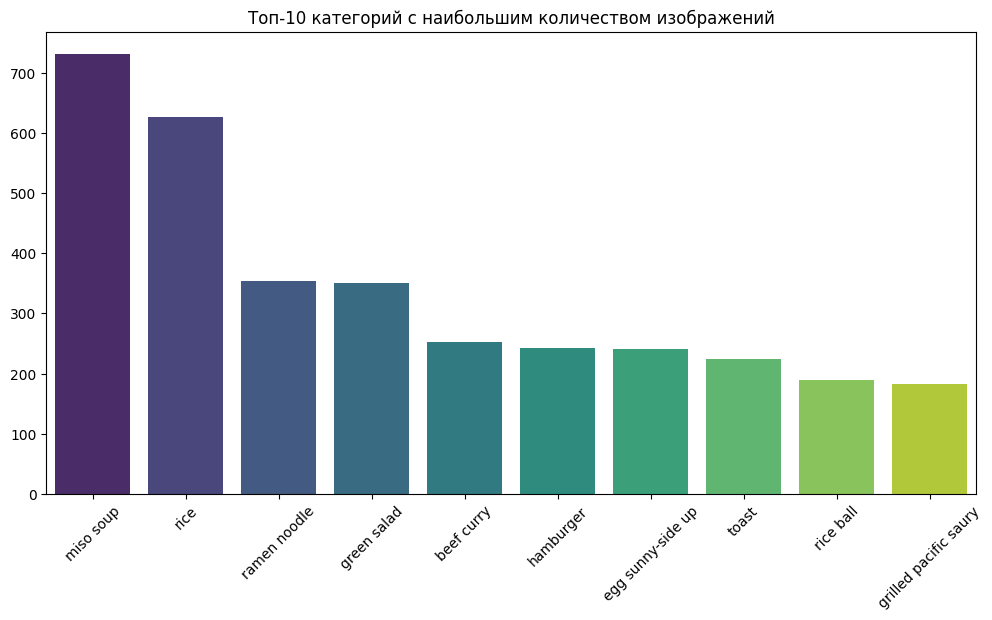

In [17]:
category_count = {category_names[i]: len(categories_images[i]) for i in range(len(category_names))}
sorted_categories = sorted(category_count.items(), key=lambda x: x[1], reverse=True)[:10] 

x=[x[0] for x in sorted_categories]
y=[x[1] for x in sorted_categories]

plt.figure(figsize=(12, 6))
sns.barplot(x=x, y=y, hue=x, palette="viridis")
plt.xticks(rotation=45)
plt.title('Топ-10 категорий с наибольшим количеством изображений')
plt.show()

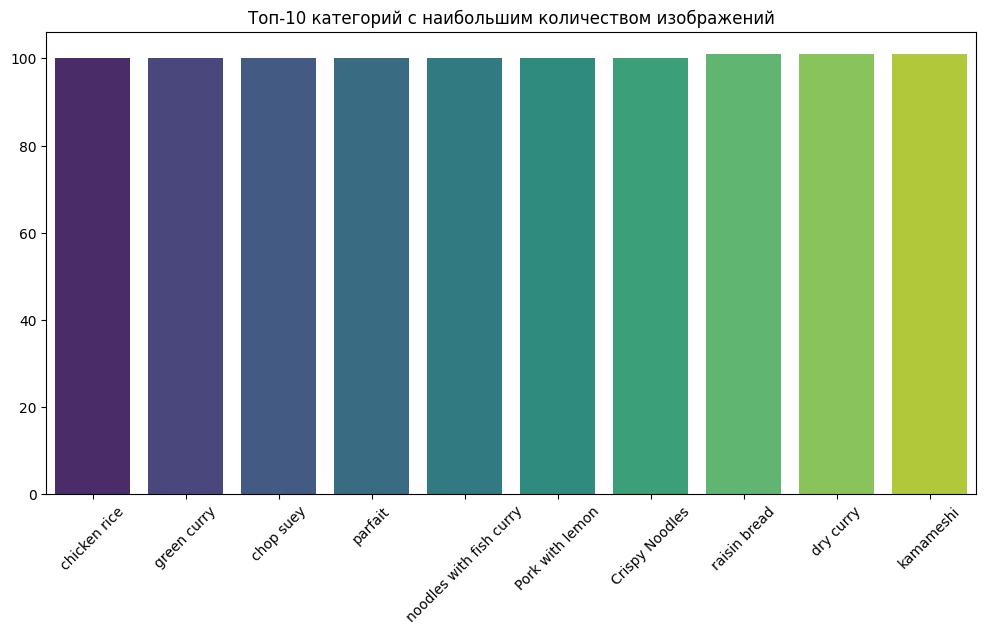

In [19]:
sorted_categories = sorted(category_count.items(), key=lambda x: x[1], reverse=False)[:10] 

x=[x[0] for x in sorted_categories]
y=[x[1] for x in sorted_categories]

plt.figure(figsize=(12, 6))
sns.barplot(x=x, y=y, hue=x, palette="viridis")
plt.xticks(rotation=45)
plt.title('Топ-10 категорий с наибольшим количеством изображений')
plt.show()

## Выводы:
1. Самая популярная категория: мисо суп

2. Минимальное кол-во изображений в рамках одной категории: 100

3. Всего категорий: 256

### Посмотрим на несколько случайных изображений из первых 3-х категорий, чтобы понимать, с какими данными будем работать:

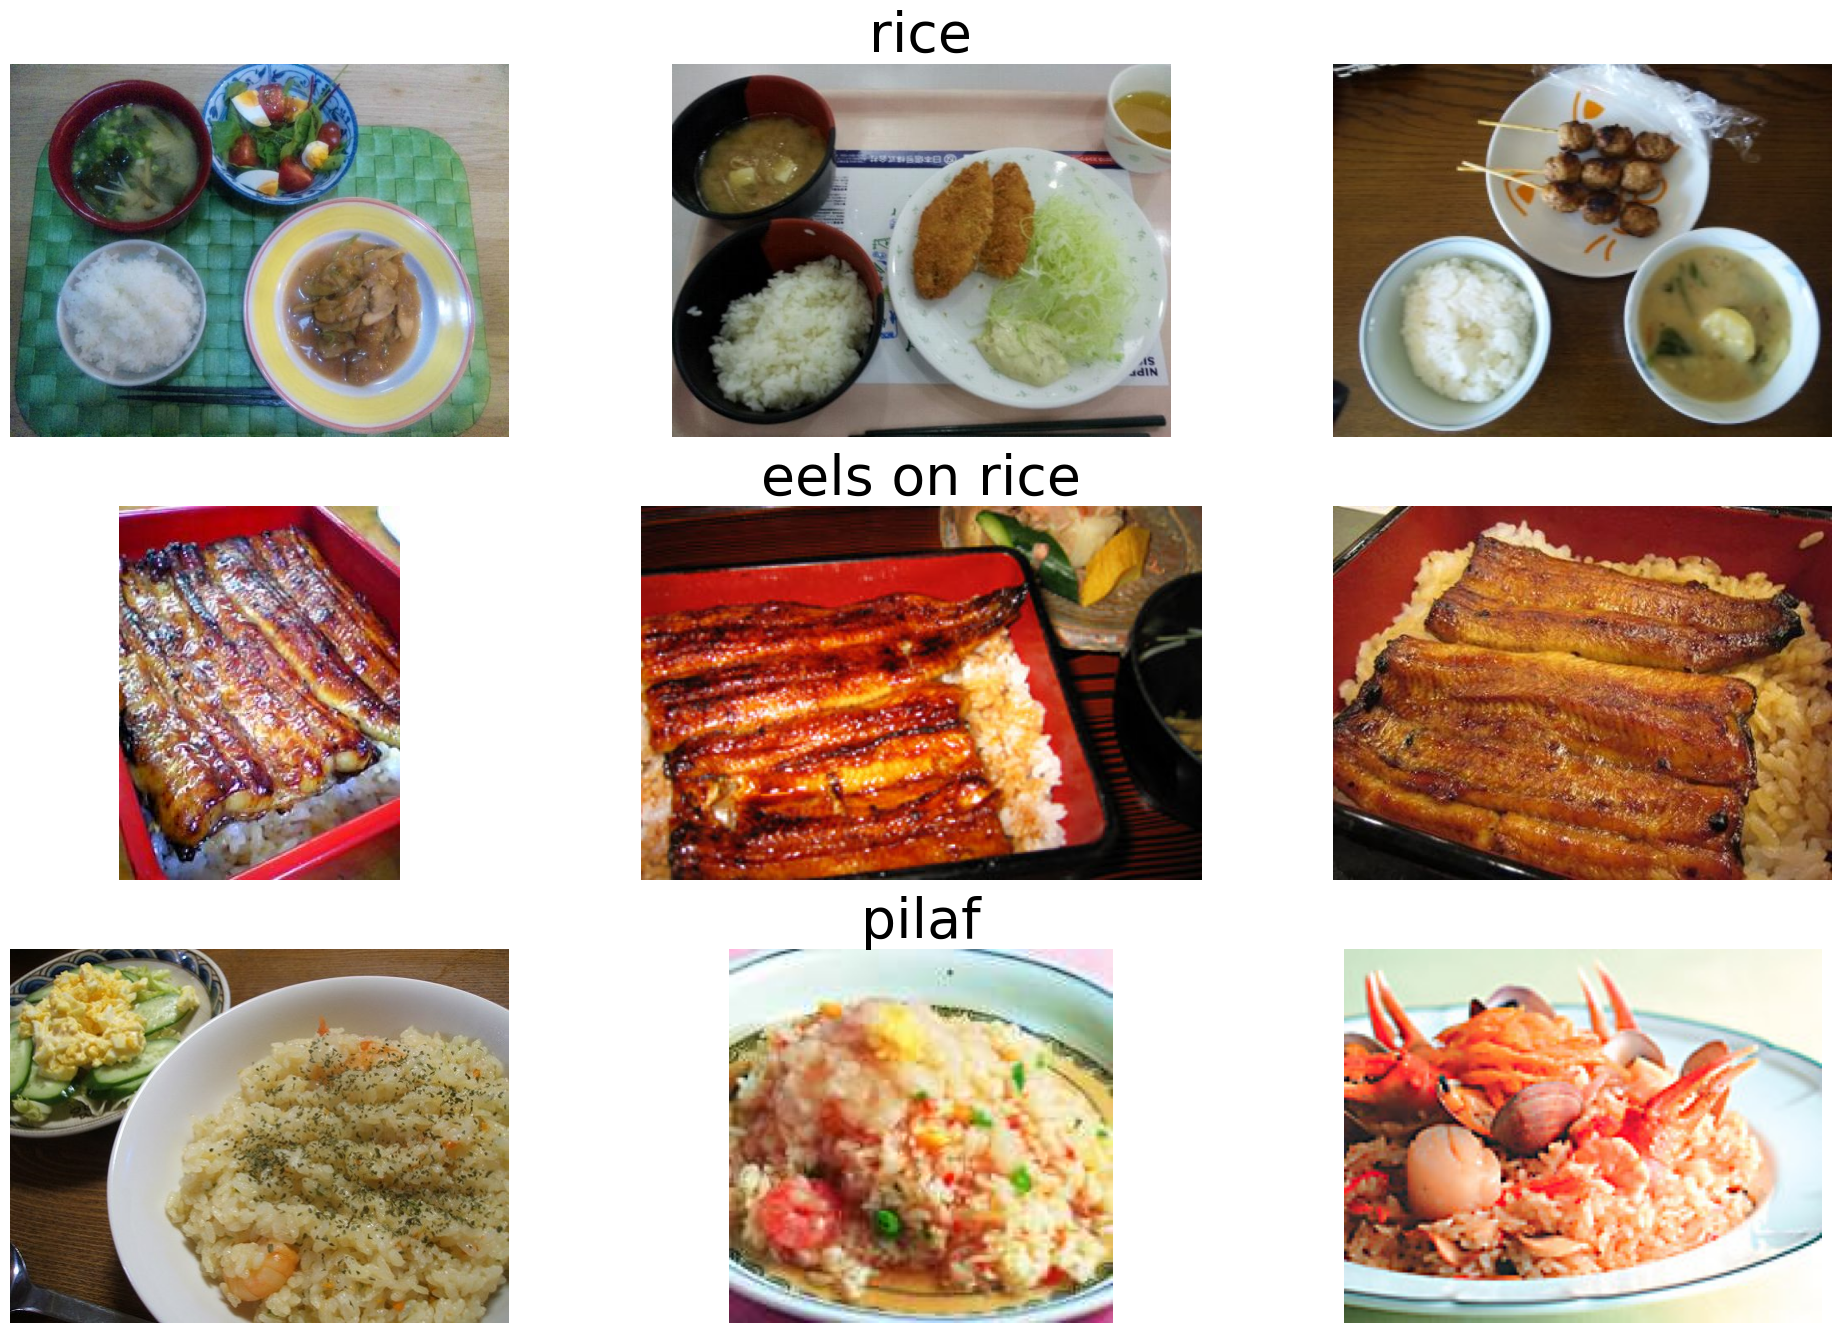

In [41]:
# Функция для отображения нескольких случайных изображений из каждой категории
def show_random_images(categories_images, category_names, n_images=3):
    plt.figure(figsize=(20,40))
    for i, category in enumerate(category_names[:3]):  # Отобразим только первые 9 категорий для примера
        for j in range(n_images):
            img_path = path + '/' + str(category_ids[i]) + '/' + categories_images[i][random.randint(0, len(categories_images[i]) - 1)] + '.' + imgs_format
            img = Image.open(img_path)
            plt.subplot(9, n_images, i * n_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == n_images // 2:
                plt.title(category, size=40)
    plt.tight_layout()
    plt.show()

# Отображаем по 3 случайных изображения из первых 9 категорий
show_random_images(categories_images, category_names)

### Данные уже размечены. Убедимся в том, что все в порядке, посмотрим на bounding boxes 

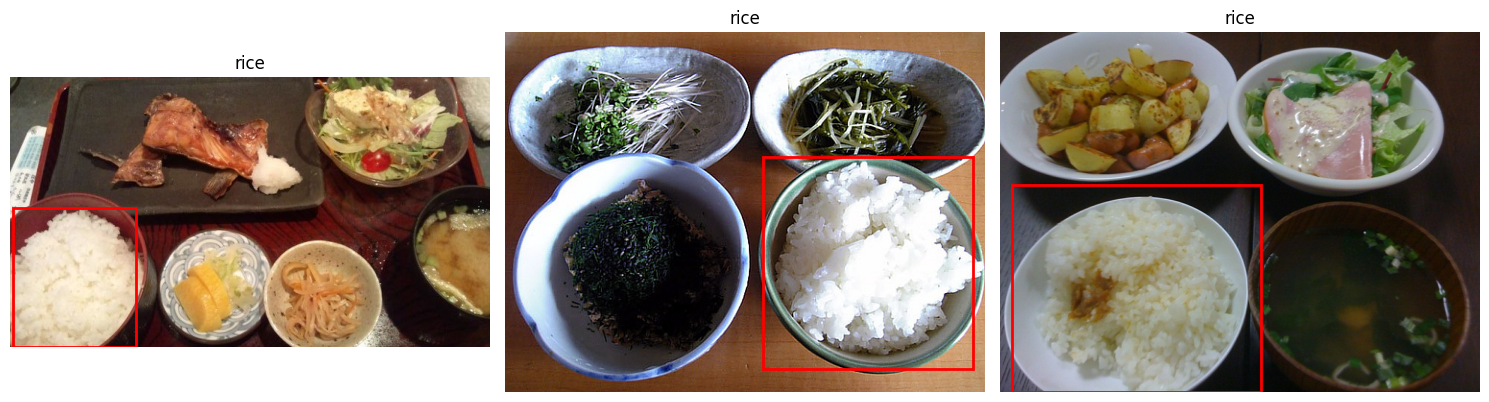

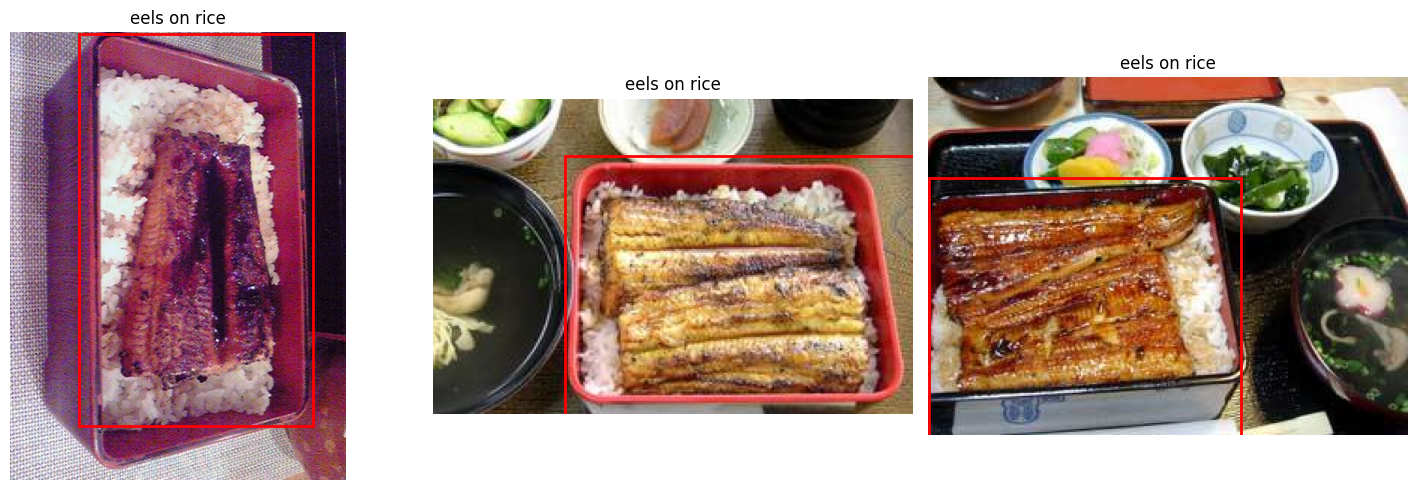

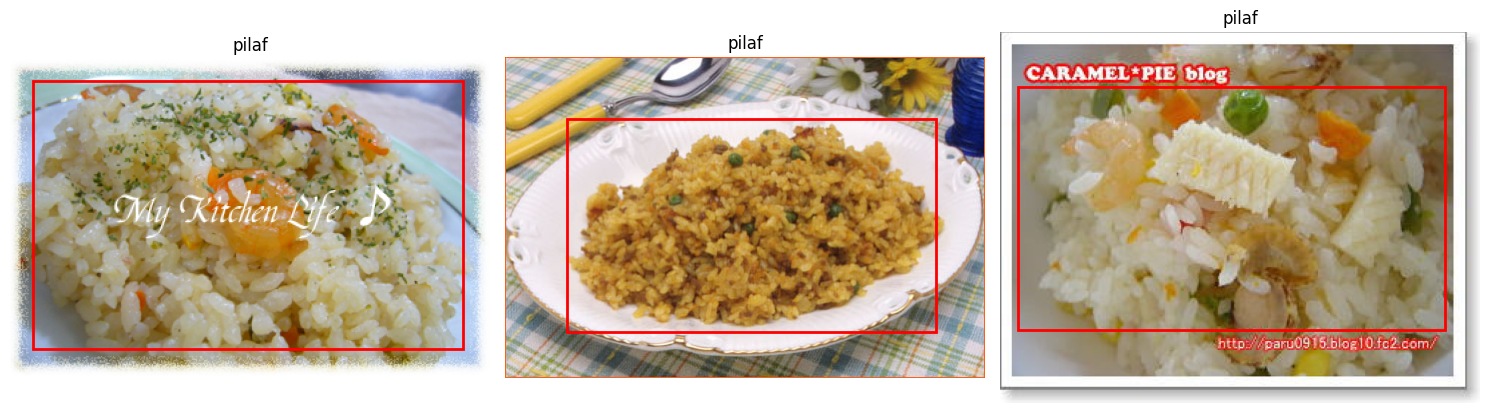

In [37]:

def show_bbox_images(categories_images, categories_bbox_info, n_images=3, n_categories=3):
    for i in range(n_categories):  # для первых трех категорий
        fig, axs = plt.subplots(1, n_images, figsize=(15, 5))
        
        for j in range(n_images):
            random_idx = random.randint(0, len(categories_images[i]) - 1)
            img_name = categories_images[i][random_idx]
            img_path = path + '/' + str(category_ids[i]) + '/' + img_name + '.' + imgs_format
            bbox = categories_bbox_info[i][random_idx]  
            
            img = Image.open(img_path)
            ax = axs[j] if n_images > 1 else axs  # cлучай с одной картинкой
            
            ax.imshow(img)

            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            ax.axis('off')
            ax.set_title(f"{category_names[i]}")
        
        plt.tight_layout()
        plt.show()

show_bbox_images(categories_images, categories_bbox_info)

In [6]:
missing_data = any(len(bbox) != 4 for bbox_info in categories_bbox_info for bbox in bbox_info)
if missing_data:
    print("В данных есть пропущенные или некорректные значения в bounding box")
else:
    print("Все значения в bounding box корректны")

Все значения в bounding box корректны


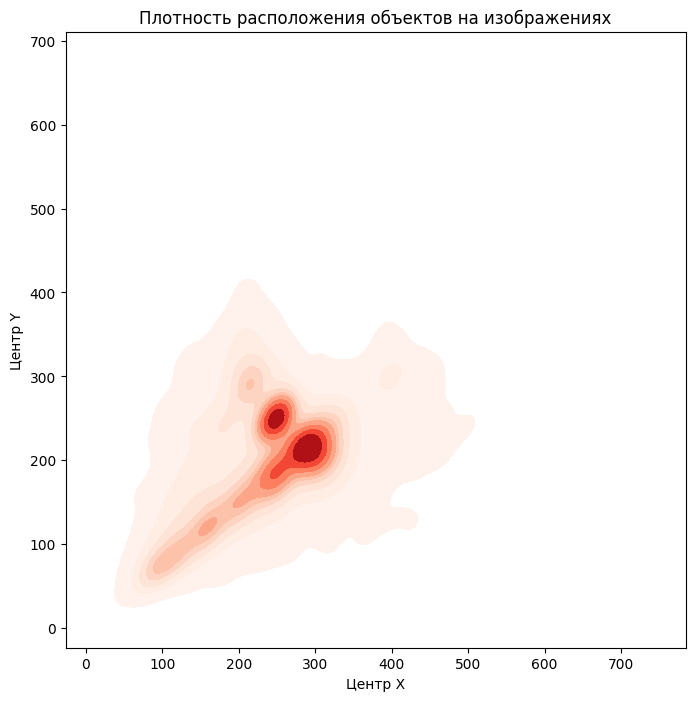

In [43]:
centers_x = [(bbox[0] + bbox[2]) / 2 for bbox_info in categories_bbox_info for bbox in bbox_info]
centers_y = [(bbox[1] + bbox[3]) / 2 for bbox_info in categories_bbox_info for bbox in bbox_info]

plt.figure(figsize=(8, 8))
sns.kdeplot(x=centers_x, y=centers_y, cmap="Reds", fill=True)
plt.xlabel("Центр X")
plt.ylabel("Центр Y")
plt.title("Плотность расположения объектов на изображениях")
plt.show()

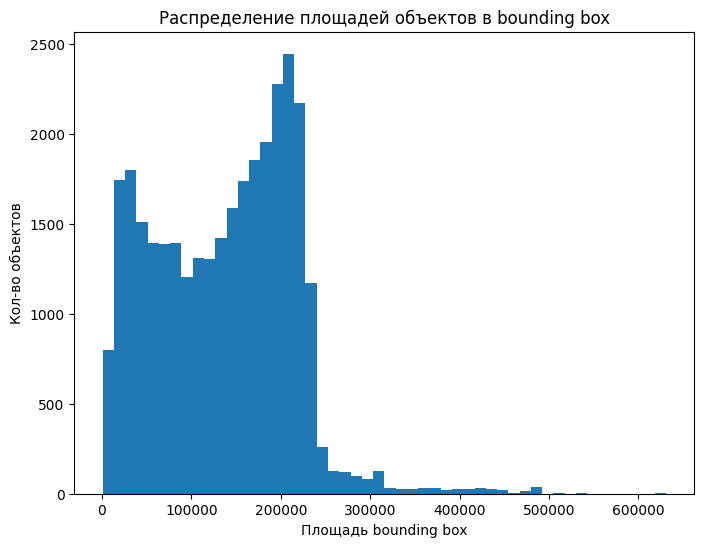

In [38]:
areas = [(bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) for bbox_info in categories_bbox_info for bbox in bbox_info]

plt.figure(figsize=(8, 6))
plt.hist(areas, bins=50)
plt.xlabel("Площадь bounding box")
plt.ylabel("Кол-во объектов")
plt.title("Распределение площадей объектов в bounding box")
plt.show()

In [7]:
unique_images = set(img for img_list in categories_images for img in img_list)
print("Количество уникальных изображений:", len(unique_images))

total_bbox_count = sum(len(bbox_info) for bbox_info in categories_bbox_info)
print("Общее количество bounding box:", total_bbox_count)

Количество уникальных изображений: 28897
Общее количество bounding box: 31645


## Выводы: 
1. По графику плотности расположения объектов на изображениях можем сделать вывод о том, что чаще всего еда расположена ближе к центру снимка

2. Видим ненормальное распределение площадей баундинг боксов. В принципе это нормально, тк мы работаем с многоклассовыми данными

3. Есть изображения с несколькими баундинг боксами